# Problema 2: Optimización Multiobjetivo en Planificación de Rutas de Inspección

## 1. Formulación del Modelo Multiobjetivo

### 1.1. Conjuntos
- $V = \{0, 1, 2, 3, \dots\}$ : Lista de nodos/localidades.
- $K = \{0, 1\}$ : Conjunto de vendedores.

### 1.2. Indices
- $i \in V$ : Nodo de origen.
- $j \in V$ : Nodo de destino.
- $k \in K$ : Índice de vendedor.

### 1.3. Parámetros
- graph: Grafo de pesos (matriz de costos entre nodos).
- ciudades: Número total de nodos.
- calidad: Es el nivel e calidad de inspección que se puede lograr en cada localidad. Por ejemplo, cada elemento $calidad_{i}$ indica la calidad del nodo $i$.
- riesgo: Indica el nivel de riesgo asociado a cada tramo de ruta. Por ejemplo,  Cada elemento $riesgo_{ij}$ indica el nivel de riesgo entre el nodo $i$ y el nodo $j$.

### 1.4. Variables de decisión
- $x_{ijk}$ binaria, que indica si el vendedor $k$ viaja de la ciudad $i$ a la ciudad $j$.
- $u_{ik}$ entera no negativa, que representa el orden en que el vendedor $k$ visita la ciudad $i$.

### 1.5. Funciones objetivo

#### Minimizar Z1 = Distancia total recorrida

Minimizar el número total de trayectos realizados por los vendedores:
$$
\min \sum_{i \in V} \sum_{j \in V} \sum_{k \in K} x_{ijk} * graph_{ij}
$$
#### Maximizar Z2 = Calidad de inspección acumulad

Maximizar la calidad de las inspecciones
$$
\max \sum_{i \in V} \sum_{j \in V} \sum_{k \in K} x_{ijk} * calidad_{i} * graph_{ij}
$$

#### Minimizar Z3 = Nivel de riesgo de la ruta

Minimizar el nivel de riesgo asociado a las rutas
$$
\min \sum_{i \in V} \sum_{j \in V} \sum_{k \in K} x_{ijk} * riesgo_{ij}
$$

### 1.6. Restricciones

#### 1. Cada ciudad se visita una vez
$$
\sum_{\substack{i \in V \\ i \ne j}} \sum_{k \in K} x_{ijk} = 1 \quad \forall j \in V \setminus \{0\}
$$

#### 2. Se sale del nodo base ($0$) una vez por vendedor
$$
\sum_{\substack{j \in V \\ j \ne 0}} x_{0jk} = 1 \quad \forall k \in K
$$

#### 3. Se retorna al nodo base ($0$) una vez por vendedor
$$
\sum_{\substack{i \in V \\ i \ne 0}} x_{i0k} = 1 \quad \forall k \in K
$$

#### 4. Flujo: cada vendedor sale de los nodos a los que entra
$$
\sum_{\substack{i \in V \\ i \ne j}} x_{ijk} = \sum_{\substack{i \in V \\ i \ne j}} x_{jik} \quad \forall j \in V \setminus \{0\}, \forall k \in K
$$

#### 5. Eliminación de subtours (formulación MTZ)
$$
u_{ik} - u_{jk} + \text{ciudades} \cdot x_{ijk} \leq \text{ciudades} - 1 \quad \forall k \in K, \forall i \in V \setminus \{0\}, \forall j \in V \setminus \{0\}
$$



## 2. Selección y Justificación del Método de Resolución:
Elegimos resolver el problema con el método de sumas ponderadas. Decidimos hacer esto principalmente por la facilidad de selección de pesos, a comparación de la selección de épsilons si hubieramos decidido usar el método de e-constraints. El objetivo de este problema era comparar diferentes soluciones, por lo que se consideró de suma importancia implementar el frente de pareto. Para hacer esto, debíamos tener múltiples respuestas del problema. Al tener este problema 3 funciones y al necesitar varias posibles soluciones, la selección de épsilons debía ser muy delicada y considerar muchos componentes. En cambio, en el método de sumas ponderadas debíamos darles a las funciones porcentajes que eran más sencillos de calcular. Así que dado que consideramos que era significativamente más complejo encontrar los valores de épsilon que los de la suma ponderada, decidimos implementar dicho método.

## 3. Implementación y Análisis

Transformed quality values: {0: 100, 1: 15, 2: 8, 3: 22, 4: 10, 5: 18, 6: 12, 7: 5, 8: 25, 9: 16}
Solving for weights: (0.0, 0.0, 1.0)
Solution found: F1=25.0, F2=424.0, F3=44.0
Successfully deleted component O_z
Successfully deleted component res1
Also deleted related component res1_index
Successfully deleted component res2
Also deleted related component res2_index
Successfully deleted component res3
Also deleted related component res3_index
Successfully deleted component res4
Also deleted related component res4_index
Successfully deleted component res5
Also deleted related component res5_index
Solving for weights: (0.0, 0.1, 0.9)
Solution found: F1=17.0, F2=301.0, F3=46.0
Successfully deleted component O_z
Successfully deleted component res1
Also deleted related component res1_index
Successfully deleted component res2
Also deleted related component res2_index
Successfully deleted component res3
Also deleted related component res3_index
Successfully deleted component res4
Also deleted

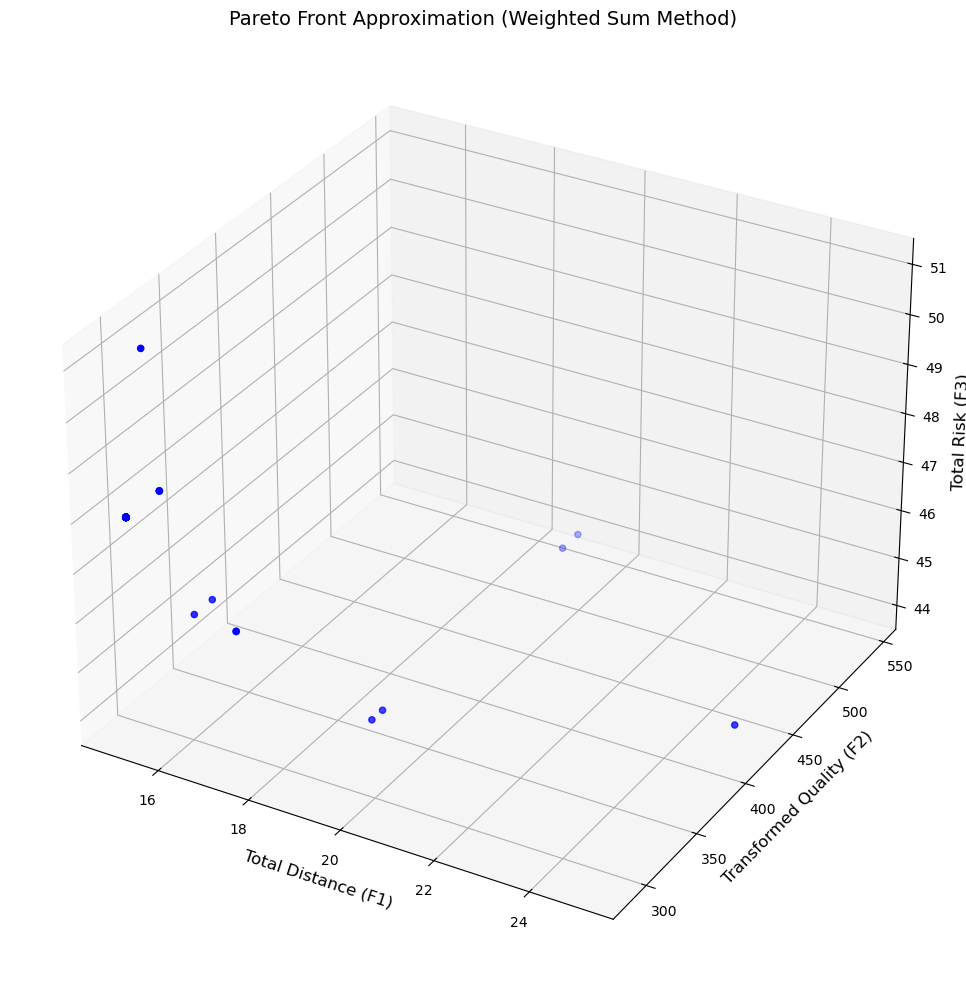

In [4]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from pyomo.environ import *
from pyomo.opt import SolverFactory


def delete_component(Model, comp_name):
    try:
        component = getattr(Model, comp_name)
        Model.del_component(component)
        print(f"Successfully deleted component {comp_name}")
    except AttributeError:
        print(f"Component {comp_name} not found")

    for attr_name in list(vars(Model).keys()):
        if attr_name.startswith(f"{comp_name}_index") or attr_name.startswith(
            f"{comp_name}_domain"
        ):
            Model.del_component(getattr(Model, attr_name))
            print(f"Also deleted related component {attr_name}")


numIteraciones = 11
w_vec = []
for i in range(numIteraciones):
    for j in range(numIteraciones - i):
        w1 = i / (numIteraciones - 1) if numIteraciones > 1 else 0
        w2 = j / (numIteraciones - 1) if numIteraciones > 1 else 0
        w3 = 1 - w1 - w2
        if w3 >= 0:
            w_vec.append((w1, w2, w3))

Model = ConcreteModel()

ciudades = 10
spread = 1.5
vendedores = 1
cota = 100

filename = f"cost_matrix_{ciudades}_nodes_{spread}_spread.csv"

try:
    data = np.loadtxt(filename, delimiter=",", dtype=int)
    nodos = list(map(int, data[0]))

    graph = {}
    for r, i in enumerate(nodos):
        for c, j in enumerate(nodos):
            if i != j:
                graph[(i, j)] = int(data[r + 1, c])
except (FileNotFoundError, OSError):
    print(f"Warning: File {filename} not found. Creating random cost matrix instead.")
    nodos = list(range(ciudades))
    graph = {(i, j): random.randint(10, 100) for i in nodos for j in nodos if i != j}

V = set(nodos)
A = {(i, j) for i in nodos for j in nodos if i != j}
K = set(range(vendedores))

calidad = {0: 0, 1: 85, 2: 92, 3: 78, 4: 90, 5: 82, 6: 88, 7: 95, 8: 75, 9: 84}

for i in calidad.keys():
    calidad[i] = cota - calidad[i]
print("Transformed quality values:", calidad)

riesgos = {}
riesgo_dados = {
    (0, 1): 3,
    (0, 2): 2,
    (0, 3): 4,
    (0, 4): 5,
    (0, 5): 6,
    (0, 6): 3,
    (0, 7): 2,
    (0, 8): 4,
    (0, 9): 5,
    (2, 8): 9,
    (2, 9): 8,
    (3, 4): 5,
    (4, 9): 7,
    (5, 6): 7,
    (8, 9): 7,
}

for (i, j), val in riesgo_dados.items():
    riesgos[(i, j)] = val
    riesgos[(j, i)] = val

for i in nodos:
    for j in nodos:
        if i != j and (i, j) not in riesgos:
            riesgos[(i, j)] = 5

Model.x = Var(A, K, within=Binary)
Model.u = Var(V, K, within=NonNegativeIntegers, bounds=(1, ciudades - 1))


def f1_expr():
    return sum(graph[(i, j)] * Model.x[i, j, k] for (i, j) in A for k in K)


def f2_expr():
    return sum(graph[(i, j)] * calidad[j] * Model.x[i, j, k] for (i, j) in A for k in K)


def f3_expr():
    return sum(riesgos[(i, j)] * Model.x[i, j, k] for (i, j) in A for k in K)


# Apply weighted sum method
f1_vec = []
f2_vec = []
f3_vec = []

for w1, w2, w3 in w_vec:
    print(f"Solving for weights: ({w1}, {w2}, {w3})")

    # Set objective function with current weights
    Model.O_z = Objective(
        expr=w1 * f1_expr() + w2 * f2_expr() + w3 * f3_expr(), sense=minimize
    )

    # Constraint 1: Each city (except depot) is visited exactly once
    Model.res1 = ConstraintList()
    for j in nodos[1:]:  # Exclude city 0 (depot)
        Model.res1.add(sum(Model.x[i, j, k] for i in nodos if i != j for k in K) == 1)

    # Constraint 2: Each salesperson leaves the depot once
    Model.res2 = ConstraintList()
    for k in K:
        Model.res2.add(sum(Model.x[0, j, k] for j in nodos[1:]) == 1)

    # Constraint 3: Each salesperson returns to the depot once
    Model.res3 = ConstraintList()
    for k in K:
        Model.res3.add(sum(Model.x[i, 0, k] for i in nodos[1:]) == 1)

    # Constraint 4: Flow conservation - enter and exit each city
    Model.res4 = ConstraintList()
    for j in nodos[1:]:  # Exclude city 0 (depot)
        for k in K:
            Model.res4.add(
                sum(Model.x[i, j, k] for i in nodos if i != j)
                == sum(Model.x[j, i, k] for i in nodos if i != j)
            )

    # Constraint 5: Subtour elimination (MTZ formulation)
    Model.res5 = ConstraintList()
    for k in K:
        for i in nodos[1:]:  # Exclude city 0 (depot)
            for j in nodos[1:]:  # Exclude city 0 (depot)
                if i != j:
                    Model.res5.add(
                        Model.u[i, k] - Model.u[j, k] + ciudades * Model.x[i, j, k]
                        <= ciudades - 1
                    )

    # Solve the model
    solver = SolverFactory("glpk")
    results = solver.solve(Model)

    # Check if solution was found
    if results.solver.status == SolverStatus.ok:
        # Calculate the objective function values manually
        valorF1 = sum(
            graph[(i, j)] * value(Model.x[i, j, k]) for (i, j) in A for k in K
        )
        valorF2 = sum(
            graph[(i, j)] * calidad[j] * value(Model.x[i, j, k])
            for (i, j) in A
            for k in K
        )
        valorF3 = sum(
            riesgos[(i, j)] * value(Model.x[i, j, k]) for (i, j) in A for k in K
        )

        f1_vec.append(valorF1)
        f2_vec.append(valorF2)
        f3_vec.append(valorF3)

        print(f"Solution found: F1={valorF1}, F2={valorF2}, F3={valorF3}")
    else:
        print("No feasible solution found for these weights")

    # Delete constraints and objective for next iteration
    delete_component(Model, "O_z")
    delete_component(Model, "res1")
    delete_component(Model, "res2")
    delete_component(Model, "res3")
    delete_component(Model, "res4")
    delete_component(Model, "res5")

# Print results
print("Weight vectors:", w_vec)
print("Total solutions found:", len(w_vec))
print("F1 values:", f1_vec)
print("F2 values:", f2_vec)
print("F3 values:", f3_vec)

# Plot Pareto front in 3D
if f1_vec and f2_vec and f3_vec:  # Only plot if we have results
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(f1_vec, f2_vec, f3_vec, c="b", marker="o")

    ax.set_title("Pareto Front Approximation (Weighted Sum Method)", fontsize=14)
    ax.set_xlabel("Total Distance (F1)", fontsize=12)
    ax.set_ylabel("Transformed Quality (F2)", fontsize=12)
    ax.set_zlabel("Total Risk (F3)", fontsize=12)

    plt.tight_layout()
    plt.show()
else:
    print("No solutions to plot")

### 7 Soluciones diferentes
Encontramos en total 64 soluciones diferentes del problema, variando los pesos de cada función. A continuación expondremos a detalle 7 de ellas. 


| # | Peso $f_1$ | Peso $f_2$ | Peso $f_3$ | Valor $f_1$ | Valor $f_2$ | Valor $f_3$ | Análisis |
|:-:|:---------:|:---------:|:---------:|:-----------:|:-----------:|:-----------:|:---------|
| 1 | 1.0       | 0.0       | 0.0       | 15          | 305         | 51          | Prioriza totalmente minimizar la distancia. Se obtiene un camino corto, pero con riesgo alto. |
| 2 | 0.0       | 1.0       | 0.0       | 15          | 287         | 48          | Prioriza calidad de inspección. Se logra la mejor calidad con un riesgo intermedio. |
| 3 | 0.0       | 0.0       | 1.0       | 25          | 424         | 44          | Prioriza minimizar el riesgo. Se aumenta mucho la distancia y el costo en calidad. |
| 4 | 0.33      | 0.33      | 0.33      | 15          | 287         | 48          | Balance equitativo entre los tres objetivos, sacrificando un poco en distancia y riesgo. |
| 5 | 0.1       | 0.1       | 0.8       | 17          | 301         | 46          | Da alta prioridad al riesgo. Mejor balance entre menor riesgo y costos aceptables. |
| 6 | 0.6       | 0.4       | 0.0       | 15          | 287         | 48          | Prioriza distancia y calidad, ignora riesgo. Se mantiene bajo costo en F1 y F2, riesgo moderado. |
| 7 | 0.5       | 0.0       | 0.5       | 16          | 320         | 46          | Balance entre distancia y riesgo, sacrificando un poco de calidad. |

### Discusión

En la exploración de las 64 soluciones obtenidas mediante la variación de los pesos, se identifican patrones claros en los trade-offs entre los objetivos de distancia (F1), calidad de inspección (F2) y riesgo (F3).

- **Priorizar únicamente un objetivo** (soluciones 1, 2 y 3) conduce a mejoras significativas en ese objetivo específico, pero a expensas de los otros:
  - Minimizar solo la distancia (solución 1) consigue un valor muy bajo de F1, pero mantiene un riesgo alto (F3=51) y una calidad aceptable.
  - Minimizar solo la calidad transformada (solución 2) optimiza F2 (baja calidad transformada implica alta calidad original), pero no mejora el riesgo ni la distancia.
  - Minimizar únicamente el riesgo (solución 3) genera la menor exposición al riesgo, pero incrementa considerablemente la distancia recorrida y el costo en calidad.

- **Balancear los objetivos** (soluciones 4, 5, 6 y 7) permite alcanzar soluciones más robustas:
  - Un reparto equitativo de pesos (solución 4) sacrifica ligeramente cada objetivo, logrando valores intermedios aceptables.
  - Dar prioridad alta al riesgo pero permitiendo peso a los otros objetivos (solución 5) reduce notablemente el riesgo sin castigar tanto la distancia ni la calidad.
  - Priorizar la distancia y la calidad sin considerar el riesgo (solución 6) mantiene bajo costo en esos dos objetivos, pero con un riesgo mayor.
  - Buscar equilibrio entre distancia y riesgo (solución 7) resulta en trayectos un poco más largos, pero más seguros, sacrificando algo de calidad.

En general, **el riesgo y la distancia muestran una relación conflictiva**: disminuir uno tiende a aumentar el otro. **La calidad**, en cambio, tiende a permanecer constante en muchas soluciones intermedias, mostrando que es un objetivo relativamente más estable frente a los cambios en los pesos.

Este análisis demuestra que dependiendo del contexto operativo (por ejemplo, si se prioriza la seguridad o la eficiencia de recursos), es posible seleccionar un conjunto de pesos adecuado para guiar la decisión hacia soluciones más convenientes.


